In [64]:
import torch
from tqdm import tqdm
import numpy as np
import sys
import matplotlib.pyplot as plt
from utils import checkpoint, warning
import utils
import MCHMC, MCLMC
import autotuning as aut
import integration_schemes as integ
import functions as funct
import visualization as vis
import importlib
from blackjax.diagnostics import effective_sample_size
import pandas as pd

In [52]:
# questo serve altrimenti non usa l'ultima versione dei file .py
importlib.reload(utils)
importlib.reload(MCHMC)
importlib.reload(MCLMC)
importlib.reload(aut)
importlib.reload(integ)
importlib.reload(funct)
importlib.reload(vis)

<module 'visualization' from '/home/ubuntu/MCHMC/visualization.py'>

# Information Theory Project

Cose da **fare**:
- Sistemare gridsearch (metrica per valutare la migliore combinazione L-eps)
- Calcolare ESS (200/n) per confronto algoritmi (tabella che ci interessa)
- Implementare altre funzioni, abbiamo solo bimodal e cauchy (che io direi di lasciare perdere dato che è incasinata)
- Implementare NUTS con NumPyro/PyMC
- Slide

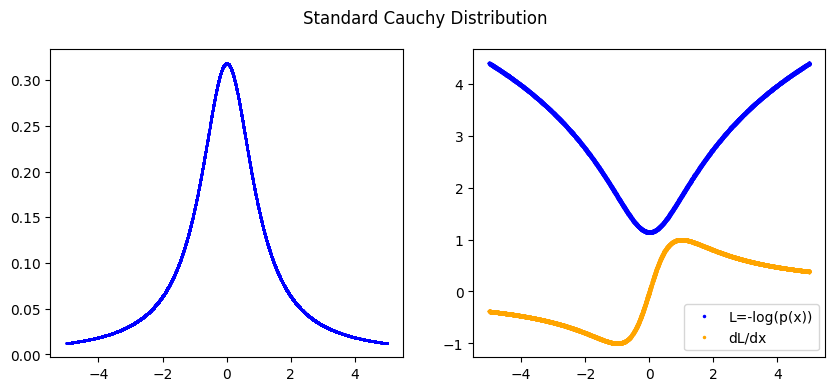

In [28]:
x = np.random.uniform(low=-5, high=5, size=(10000, 1))
L = -np.log(funct.standard_cauchy(x).detach().numpy())
nablaL = integ.grad_log_likelihood(x, funct.standard_cauchy).numpy()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(x, funct.standard_cauchy(x).numpy(), 'o', c='blue', ms=1)

axes[1].plot(x, L, 'o', color='blue', markersize=1.5, label='L=-log(p(x))')
axes[1].plot(x, nablaL, 'o', color='orange', markersize=1.5, label='dL/dx')
axes[1].legend()

fig.suptitle('Standard Cauchy Distribution')
plt.show()

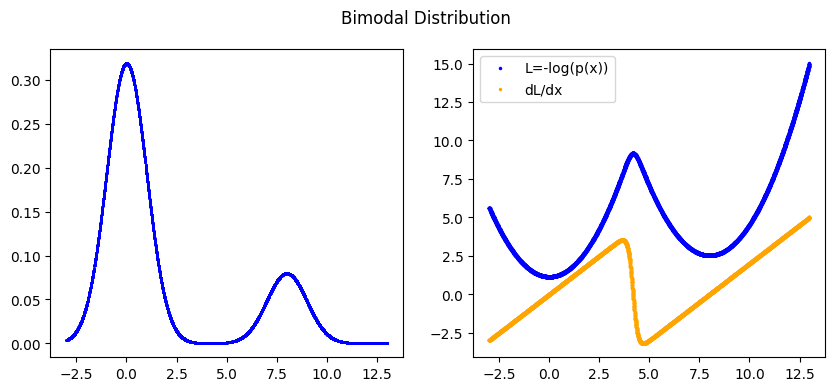

In [29]:
x = np.random.uniform(low=-3, high=13, size=(10000, 1))
L = -np.log(funct.bimodal(x).to("cpu").detach().numpy())
nablaL = integ.grad_log_likelihood(x, funct.bimodal).numpy()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(x, funct.bimodal(x).to("cpu").numpy(), 'o', c='blue', ms=1)

axes[1].plot(x, L, 'o', color='blue', markersize=1.5, label='L=-log(p(x))')
axes[1].plot(x, nablaL, 'o', color='orange', markersize=1.5, label='dL/dx')
axes[1].legend()

fig.suptitle('Bimodal Distribution')
plt.show()

## Microcanonical Hamiltonian Montecarlo

Let's start with the tuning of $\epsilon$ and L for the bimodal function, it should converge (ma loro hanno fatto $10^7$ steps).

In [27]:
# Optimizing L
N_opt = 10
d = 100
eps_opt = np.sqrt(d) # default
sigma_eff = aut.sigma_eff(d=d, N=500, L=10, fn=funct.bimodal, algorithm=MCHMC.MCHMC_bounces)

L_values = aut.tune_L(sigma_eff, eps_opt, d, N=500, fn=funct.bimodal, algorithm=MCHMC.MCHMC_bounces, iterations=N_opt)
L_opt = np.mean(L_values)
print(f'Optimal L: {L_opt}')


Running 10 iterations of <function MCHMC_bounces at 0x7f1f221efb50> with 500 steps, updating L


Running iterations: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.28s/it]

Optimal L: 9.14866044939058


In [38]:
# Optimizing epsilon
#eps_values, targets = aut.tune_eps(d=100, N=500, L=10, fn=funct.bimodal, algorithm=MCHMC.MCHMC_bounces, iterations=N_opt)
#epsilon_opt = np.mean(eps_values)
#epsilon_opt = 0.75 * L_opt
print(epsilon_opt)
print(eps_values)


Running 10 iterations of <function MCHMC_bounces at 0x7f1f0e162560> with 500 steps, updating epsilon


Running iterations: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.18s/it]

0.9852786898612976
[0.93602341 0.90519786 1.08742905 0.96797836 0.96952564 0.90885311
 1.04860616 0.97724855 1.11952722 0.93239754]


We have implemented the procedure reported in the paper for the tuning of $\epsilon$, but it leads to strange values. Here we try to perform a gridsearch based on the naive idea that $\epsilon = n \cdot L$, with $n \sim 7.5$.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [10:16<00:00, 123.31s/it]


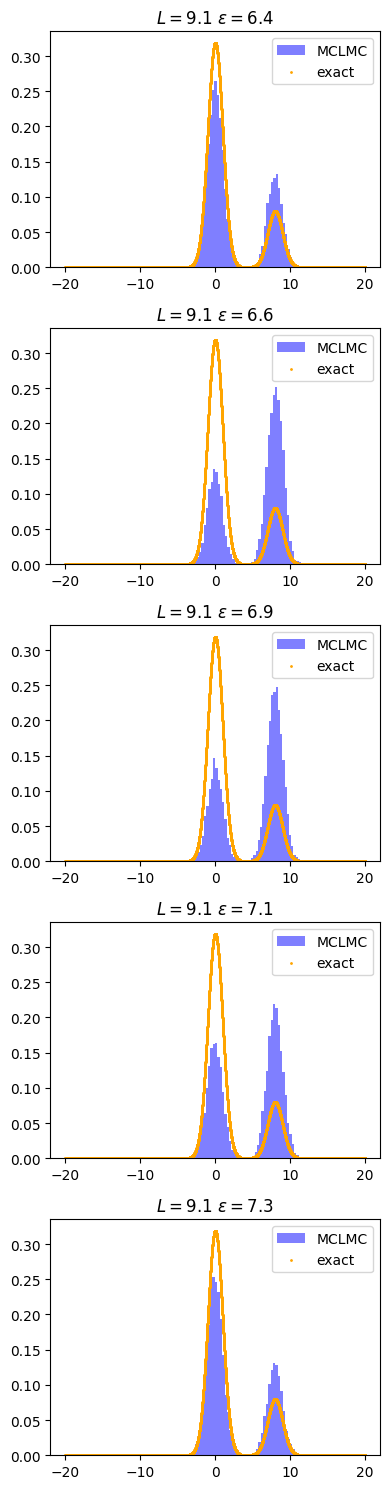

In [62]:
N_grid = 5
N_samples = 5000
dim = 100
iterations = 3
n = np.linspace(0.7, 0.8, N_grid)
eps = n * L_opt
gfig, gax = plt.subplots(N_grid, figsize=(4, 3*N_grid))
records = []

for i in tqdm(range(len(eps))):
    e = eps[i]
    gax[i].set_title(rf'$L = {L_opt:.1f}$ $\epsilon = {e:.1f}$')
    Xt = np.zeros((iterations, N_samples+1, dim))
    
    for j in range(iterations):
        X, *_ = MCHMC.MCHMC_bounces(d=dim, N=N_samples, L=L_opt, epsilon=e, fn=funct.bimodal)
        X = X.to("cpu").detach().numpy()
        Xt[j] = X
        
    x = np.linspace(-20, 20, 10000)
    record = {}
    record['L'] = L_opt
    record['epsilon'] = e
    record['L/e'] = L_opt/e
    Xt = Xt.reshape(iterations * (N_samples+1), dim)
    gax[i].hist(Xt[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCLMC')
    gax[i].scatter(x, funct.bimodal(x).to("cpu").numpy(), color='orange', s=1, label='exact')
    gax[i].legend()
    #compute mean, stdev
    record['mean'] = Xt[:, 0].mean()
    record['std'] = Xt[:, 0].std()
    #Other metrics??
    records.append(record)
plt.tight_layout()
plt.savefig('grid.svg')
plt.show()

In [63]:
df = pd.DataFrame(records)
df.head(len(df))

,L,epsilon,L/e,mean,std
0,9.14866,6.404062,1.428571,2.663049,3.894573
1,9.14866,6.632779,1.379310,5.328387,3.945021
2,9.14866,6.861495,1.333333,5.212692,3.940627
3,9.14866,7.090212,1.290323,4.526715,4.114134
4,9.14866,7.318928,1.250000,2.623693,3.912506


The mean should be $0.2\times 8 = 1.6$ and the standard deviation should be $\approx 3.35$

In [65]:
X, *_ = MCHMC.MCHMC_bounces(d=100, N=20000, L=9.14866, epsilon=6.404062, fn=funct.bimodal, pbar=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:46<00:00, 120.48it/s]


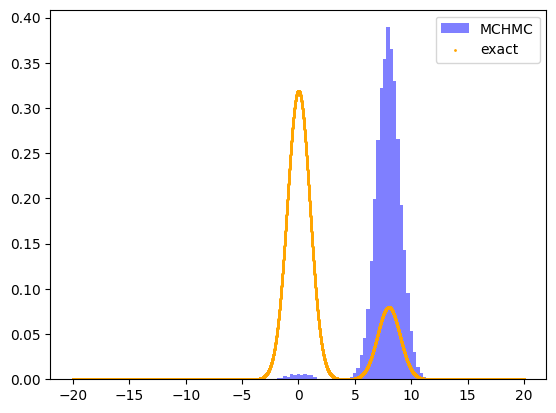

In [66]:
X = X.to("cpu").detach().numpy()
x = np.linspace(-20, 20, 10000)
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCHMC')
plt.scatter(x, funct.bimodal(x).to("cpu").numpy(), color='orange', s=1, label='exact')
plt.legend()
plt.show()

Fa cagare perchè bisognerebbe comunque runnare più chain in parallelo con diverse inizializzazioni. 

## Langevin-like Hamiltonian Montecarlo

In [37]:
# Optimizing epsilon
L = torch.tensor(10, device=utils.choose_device())
eps_values, sigma_effs = aut.tune_eps(d=1000, N=300, L=L, fn=funct.bimodal, algorithm=MCLMC.MCLMC, iterations=5)

epsilon_opt = eps_values.mean()
sigma_eff = sigma_effs.mean()
print(f'Optimal epsilon: {epsilon_opt}')


Running 5 iterations of <function MCLMC at 0x7efb5a2765f0> with 300 steps, updating epsilon


100%|████████████████████████████████████████| 300/300 [00:02<00:00, 118.04it/s]

Optimal epsilon: 8.200236320495605


In [38]:
L_values = aut.tune_L(sigma_eff, epsilon_opt, d=1000, N=300, fn=funct.bimodal, algorithm=MCLMC.MCLMC, iterations=5, debug=False, cauchy=False)

L_opt = L_values.mean()
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCLMC at 0x7efb5a2765f0> with 300 steps, updating L


100%|████████████████████████████████████████| 300/300 [00:02<00:00, 115.85it/s]


Optimal L: 9.536748886108398


In [39]:
X, *_ = MCLMC.MCLMC(d=1000, N=10000, L=L_opt, epsilon=epsilon_opt, fn=funct.bimodal)

100%|████████████████████████████████████| 10000/10000 [01:27<00:00, 114.59it/s]


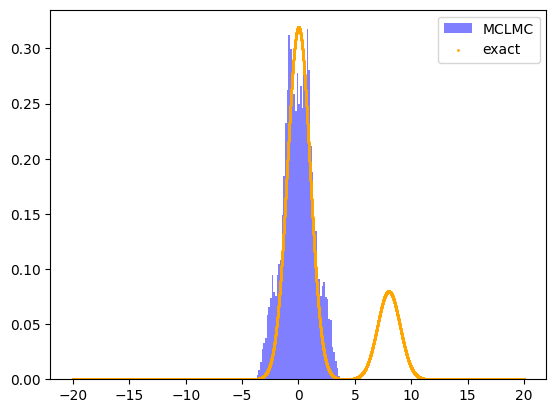

In [40]:
X = X.to("cpu").detach().numpy()

'''
d=1000
mu1 = np.zeros(d)
mu2 = np.full((d,), 8.0 / np.sqrt(d))
separation_axis = mu1-mu2
u = separation_axis / np.norm(separation_axis)
X_proj = samples @ unit_vec
'''

x = np.linspace(-20, 20, 10000)
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCLMC')
plt.scatter(x, funct.bimodal(x).to("cpu").numpy(), color='orange', s=1, label='exact')
plt.legend()
plt.show()

In [41]:
# Optimizing epsilon
L = torch.tensor(10, device=utils.choose_device())
eps_values, sigma_effs = aut.tune_eps(d=2, N=300, L=L, fn=funct.bimodal, algorithm=MCLMC.MCLMC, iterations=5)

epsilon_opt = eps_values.mean()
sigma_eff = sigma_effs.mean()
print(f'Optimal epsilon: {epsilon_opt}')

L_values = aut.tune_L(sigma_eff, epsilon_opt, d=1000, N=300, fn=funct.bimodal, algorithm=MCLMC.MCLMC, iterations=5, debug=False, cauchy=False)

L_opt = L_values.mean()
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCLMC at 0x7efb5a2765f0> with 300 steps, updating epsilon


100%|████████████████████████████████████████| 300/300 [00:02<00:00, 117.61it/s]


Optimal epsilon: 0.4657119810581207

Running 5 iterations of <function MCLMC at 0x7efb5a2765f0> with 300 steps, updating L


100%|████████████████████████████████████████| 300/300 [00:02<00:00, 111.65it/s]


Optimal L: 16.09433364868164


100%|████████████████████████████████████| 10000/10000 [01:26<00:00, 115.31it/s]


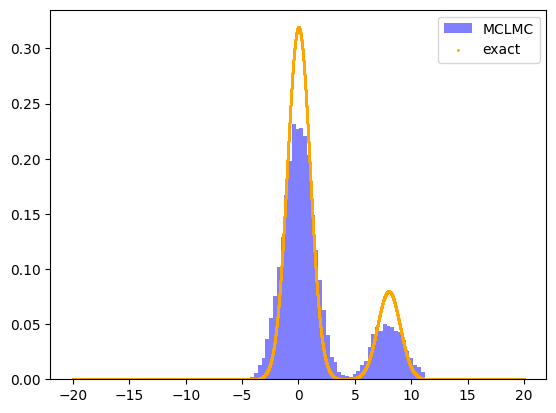

In [42]:
X, *_ = MCLMC.MCLMC(d=2, N=10000, L=L_opt, epsilon=epsilon_opt, fn=funct.bimodal)

X = X.to("cpu").detach().numpy()
x = np.linspace(-20, 20, 10000)
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCLMC')
plt.scatter(x, funct.bimodal(x).to("cpu").numpy(), color='orange', s=1, label='exact')
plt.legend()
plt.show()

## Naive parameter tuning

To investigate the reasons for the failure to capture the two modes we will do a rough grid search across a few orders of magnitude.